In [2]:
# -*- coding: utf-8 -*-

import tensorflow as tf ###Building a neural network
import numpy as np###Used for matrix calculation

import os
import matplotlib.pyplot as plt  ##For drawing
%matplotlib inline
from imageio import imread, imsave, mimsave  ###Image processing related functions
from scipy.misc import imresize   ##For image cropping
import glob

19200


In [4]:
dataset = 'RS_Cut_Result' ### Data folder
images = glob.glob(os.path.join(dataset, '*.*'))   ##Traverse the data folder
print(len(images))

In [5]:
batch_size = 100  ###Use 100 samples at a time
z_dim = 100  ###Finally generate a picture from 100 dimensions
WIDTH = 64  ###Picture length, width and height
HEIGHT = 64

OUTPUT_DIR = 'samples_' + dataset  ##Store the generated image address
if not os.path.exists(OUTPUT_DIR):  ###If the 6-line folder does not exist, a folder is created on the 8th line.。
    os.mkdir(OUTPUT_DIR)

X = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='X')   ###The construction must first add the assumption that there is data, this placoolder is to first assume a data
noise = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='noise')  ###Assuming a noisy data
is_training = tf.placeholder(dtype=tf.bool, name='is_training')  ##Let's assume a variable, which is used to control training or testing

def lrelu(x, leak=0.2):   ###Activation function
    return tf.maximum(x, leak * x)  ###This is the formula of the activation function

def sigmoid_cross_entropy_with_logits(x, y):  ###Define loss function
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y)  ##Cross entropy loss

In [6]:
def discriminator(image, reuse=None, is_training=is_training):  ###Build the discriminator
    momentum = 0.9 ###Charge: Mainly used to slow down overfitting
    with tf.variable_scope('discriminator', reuse=reuse): ###Set up a namespace
        h0 = lrelu(tf.layers.conv2d(image, kernel_size=5, filters=64, strides=2, padding='same'))####Convolution operation, and get the result call the activation function
        
        h1 = tf.layers.conv2d(h0, kernel_size=5, filters=128, strides=2, padding='same')
        h1 = lrelu(tf.contrib.layers.batch_norm(h1, is_training=is_training, decay=momentum))
        
        h2 = tf.layers.conv2d(h1, kernel_size=5, filters=256, strides=2, padding='same')
        h2 = lrelu(tf.contrib.layers.batch_norm(h2, is_training=is_training, decay=momentum))
        
        h3 = tf.layers.conv2d(h2, kernel_size=5, filters=512, strides=2, padding='same')
        h3 = lrelu(tf.contrib.layers.batch_norm(h3, is_training=is_training, decay=momentum))
        
        h4 = tf.contrib.layers.flatten(h3)  ###Feature map obtained by stretching convolution
        h4 = tf.layers.dense(h4, units=1) ##Fully connected layer
        return tf.nn.sigmoid(h4), h4   ###Return calculation result

In [7]:
def generator(z, is_training=is_training):###Define the generative model
    momentum = 0.9
    with tf.variable_scope('generator', reuse=None):
        d = 4
        h0 = tf.layers.dense(z, units=d * d * 512)##Fully connected layer
        h0 = tf.reshape(h0, shape=[-1, d, d, 512])  ###Dimensional adjustment
        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(h0, is_training=is_training, decay=momentum))####Convolution operation, and get the result call the activation function
        
        h1 = tf.layers.conv2d_transpose(h0, kernel_size=5, filters=256, strides=2, padding='same')
        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(h1, is_training=is_training, decay=momentum))
        
        h2 = tf.layers.conv2d_transpose(h1, kernel_size=5, filters=128, strides=2, padding='same')
        h2 = tf.nn.relu(tf.contrib.layers.batch_norm(h2, is_training=is_training, decay=momentum))
        
        h3 = tf.layers.conv2d_transpose(h2, kernel_size=5, filters=64, strides=2, padding='same')
        h3 = tf.nn.relu(tf.contrib.layers.batch_norm(h3, is_training=is_training, decay=momentum))
        
        h4 = tf.layers.conv2d_transpose(h3, kernel_size=5, filters=3, strides=2, padding='same', activation=tf.nn.tanh, name='g')
        return h4

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.flatten instead.


In [8]:
g = generator(noise)  ###Instantiate the generator and add noise (this noise will eventually be generated as a picture)
d_real, d_real_logits = discriminator(X)   ####Enter X and put it in the discriminator to judge
d_fake, d_fake_logits = discriminator(g, reuse=True)####Throw in the things generated by the generator to judge

vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]  ###Find the parameters that need to be trained in the generator
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

loss_d_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_real_logits, tf.ones_like(d_real)))  ####Calculate the average loss after the real picture is judged
loss_d_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake_logits, tf.zeros_like(d_fake)))  ####Fake picture loss
loss_g = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake_logits, tf.ones_like(d_fake)))     ###Generator loss
loss_d = loss_d_real + loss_d_fake ####The loss of the discriminator

In [9]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)   ###Take out the variables that need to be optimized
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_d, var_list=vars_d)  ####Optimization
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_g, var_list=vars_g)

In [10]:
def read_image(path, height, width):  ###Function to read pictures
    image = imread(path)   
    h = image.shape[0]
    w = image.shape[1]
    
    if h > w:   ###Cut to the shortest side
        image = image[h // 2 - w // 2: h // 2 + w // 2, :, :]
    else:
        image = image[:, w // 2 - h // 2: w // 2 + h // 2, :]    
    
    image = imresize(image, (height, width))  ###Crop
    return image / 255. ###Dividing by 255 is normalization, the purpose is to make the model converge faster

C:\Users\ls\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # This is added back by InteractiveShellApp.init_path()
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0 1.597357 0.5349887


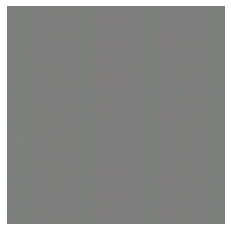

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


3000 1.5009174 0.69997185


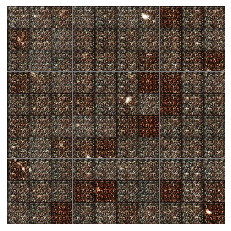

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


6000 1.4263562 0.65894836


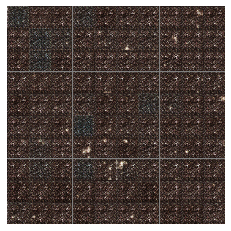

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


9000 1.4015877 0.67742217


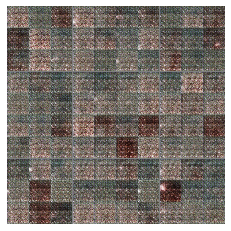

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


12000 1.1742294 0.9041254


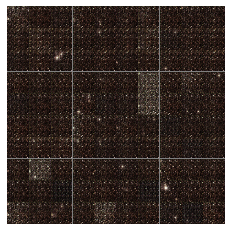

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


15000 1.5470166 0.31349513


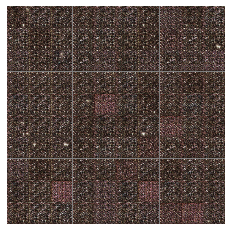

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


18000 0.754578 1.7888678


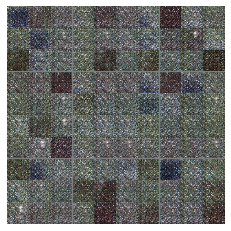

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


21000 1.366474 4.918283


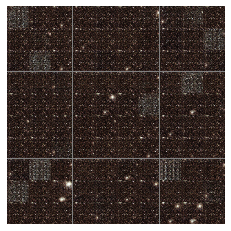

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


24000 0.40538305 2.3204827


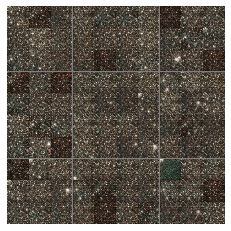

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


27000 1.1294634 0.6368166


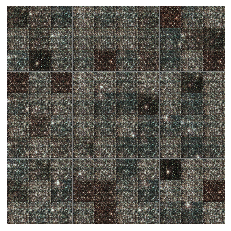

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


30000 0.932356 0.9354436


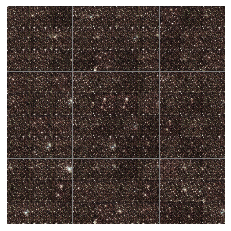

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


33000 0.28093332 2.1978855


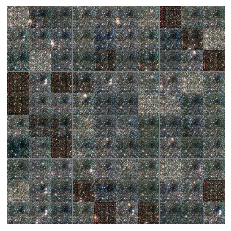

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


36000 0.32307166 4.290275


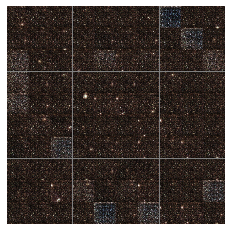

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


39000 0.3742763 1.6264033


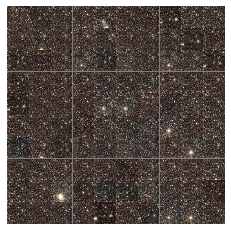

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


42000 0.2568788 2.9817474


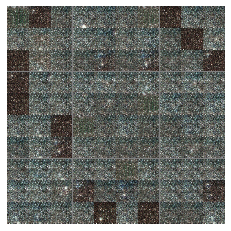

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


45000 0.20800993 2.5789185


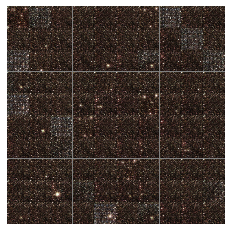

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


48000 0.08201254 4.1003876


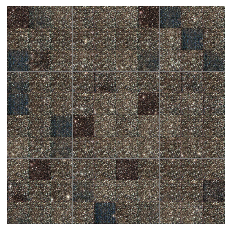

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


51000 0.7933054 1.0855811


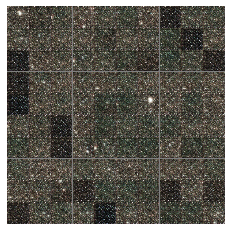

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


54000 0.1038403 3.2777064


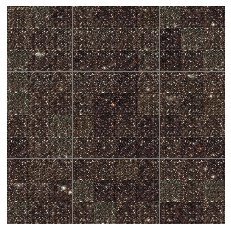

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


57000 0.09365177 4.4277844


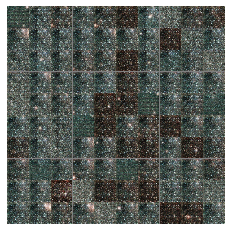

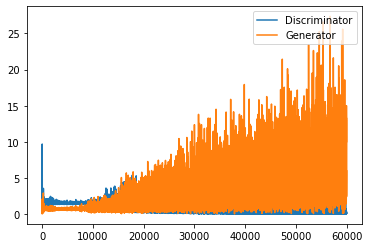

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [11]:
def montage(images):       ####What we use for drawing is to visualize the matrix we generated
    if isinstance(images, list):
        images = np.array(images)  ###Turn the data into a matrix
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))  ###When calculating how many positions we need to draw a picture, one picture is one position. For example, if there are 100 pictures, then there can be 10 rows and 10 columns. sqrt is the square root.
    if len(images.shape) == 4 and images.shape[3] == 3:  ###If the picture is four dimensions, and the last dimension is 3
        m = np.ones(           #####First generate a matrix of all 1s
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    elif len(images.shape) == 4 and images.shape[3] == 1:   ####If it is grayscale
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 1)) * 0.5
    elif len(images.shape) == 3:   ###If there are only three dimensions
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    else:
        raise ValueError('Could not parse image shape of {}'.format(images.shape))   ####If the dimension is not 3 or 4, an error will be reported
    for i in range(n_plots):   ###Loop, put pictures in one place by place. Loop rows (for example, I have 10 rows and 10 columns, first traverse the rows)
        for j in range(n_plots):####Iterate over the columns
            this_filter = i * n_plots + j  ####Calculate the precise position of the picture, such as 2 rows and 3 columns, which is the 13th
            if this_filter < images.shape[0]:  ###For example, if there are 100 pictures, the position must be less than 100. If it is greater than 100, it will be an error.
                this_img = images[this_filter]        ###Extract the corresponding data
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

In [12]:
sess = tf.Session()  ###Start preparing for training (before the definition, not training)
sess.run(tf.global_variables_initializer()) ###Initialize some necessary parameters
z_samples = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)  ###Generate sampled data set
samples = []  ###Used to store pictures and make gif animations
loss = {'d': [], 'g': []}  ###Used to store loss

offset = 0  
for i in range(60000):   ###Training 6W rounds
    n = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)###Generate evenly distributed noise data
    
    offset = (offset + batch_size) % len(images)
    batch = np.array([read_image(img, HEIGHT, WIDTH) for img in images[offset: offset + batch_size]])   ###Generate batch data
    batch = (batch - 0.5) * 2   ###The data is processed, this is the real data
    
    d_ls, g_ls = sess.run([loss_d, loss_g], feed_dict={X: batch, noise: n, is_training: True})  ###Calculate the loss of the generator and the discriminator
    loss['d'].append(d_ls)  ###Save the loss and use it for drawing later
    loss['g'].append(g_ls)
    
    sess.run(optimizer_d, feed_dict={X: batch, noise: n, is_training: True})  ###Optimize the weight of the discriminator (that is, the bp algorithm)
    sess.run(optimizer_g, feed_dict={X: batch, noise: n, is_training: True})
    sess.run(optimizer_g, feed_dict={X: batch, noise: n, is_training: True})
        
    if i % 3000 == 0:   ###Every 3000 times, draw the generated results
        print(i, d_ls, g_ls)
        gen_imgs = sess.run(g, feed_dict={noise: z_samples, is_training: False})   ###Get the build result
        gen_imgs = (gen_imgs + 1) / 2
        imgs = [img[:, :, :] for img in gen_imgs]
        gen_imgs = montage(imgs)  ###Generate results and draw pictures
        plt.axis('off')
        plt.imshow(gen_imgs)
        imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), gen_imgs)
        plt.show()
        samples.append(gen_imgs)

    plt.plot(loss['d'], label='Discriminator')  ##Drawing
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')   ###Legend
plt.savefig(os.path.join(OUTPUT_DIR, 'Loss.png'))  ###Save Picture
plt.show()
mimsave(os.path.join(OUTPUT_DIR, 'samples.gif'), samples, fps=10)

'samples_RS_Cut_Result\\dcgan_RS_Cut_Result-10000'

In [ ]:
saver = tf.train.Saver()   ###Instantiate the class that saves the model
saver.save(sess, os.path.join(OUTPUT_DIR, 'dcgan_' + dataset), global_step=60000)  ###Save the model